In [97]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  

In [98]:
hotels = pd.read_csv('C:\Temp\Pythone/hotels.csv')

In [99]:
hotels.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671


In [100]:
#проверим на дубликаты и удалим
#dupl_columns = list(hotels.columns)

#mask = hotels.duplicated(subset=dupl_columns)
#hotels_duplicates = hotels[mask]
#print(f'Число найденных дубликатов: {hotels_duplicates.shape[0]}')

#hotels = hotels.drop_duplicates(subset=dupl_columns)
#print(f'Результирующее число записей: {hotels.shape[0]}')

In [101]:
#заполним пропуски
hotels = hotels.fillna(hotels.median())
hotels.info()

C:\Users\e.korenkova\AppData\Local\Temp\ipykernel_5780\1304622715.py:2: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  hotels = hotels.fillna(hotels.median())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

 1. Предобработка признаков
   
* 1.1 кол-во дней прибывания в отеле 'nights' из 'tags'
* 1.2 уникальными отзывами 'unique_reviews' из 'tags'
* 1.3 страна отеля 'country_hotel' из 'hotel_address'
*  Создание категориальных признаков:
* 1.4 для 'unique_reviews', <15 используем  OneHotEncoder
* 1.5 для 'country_hotel', <15 используем  OneHotEncoder
* 1.6 для 'reviewer_nationality'> 15, используем BinaryEncoder
* 1.7 для переводим признак из формата object в int64


In [102]:
# 1.1  кол-во дней прибывания в отеле
regex = '\d{1}' # регулярное выражение для нахождения чисел

hotels['nights'] = hotels['tags'].str.findall(regex).str.get(0)
#hotels1= pd.concat([hotels, hotels['nights']], axis=1)
#hotels['nights']=hotels['nights'].astype(str).astype(float)
#hotels.fillna(hotels.median(), inplace=True)

In [103]:
# 1.2. создадим колонку с уникальными отзывами
hotels['unique_reviews'] = hotels['tags'].str.rstrip().str.split( ).str[1] 
hotels['unique_reviews'].value_counts()

Leisure      312768
Business      61846
Couple         4346
Solo           3216
Family         2349
Group          1188
With           1045
Travelers        45
Name: unique_reviews, dtype: int64

In [104]:
# 1.3. Создадим признак Страна отеля
hotels['country_hotel'] = hotels['hotel_address'].str.extract(r'(\w+)$') # колока Страны

In [105]:
hotels.head(1)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,nights,unique_reviews,country_hotel
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,2,Leisure,Kingdom


In [106]:
# 1.4 создание категориального признака для 'unique_reviews'
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['unique_reviews'], use_cat_names=True) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels['unique_reviews'])
hotels = pd.concat([hotels, type_bin], axis=1)

In [107]:
# 1.5 создание категориального признака для 'country_hotels'
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['country_hotel'], use_cat_names=True) # указываем столбец для кодирования
type_bin1 = encoder.fit_transform(hotels['country_hotel'])
hotels = pd.concat([hotels, type_bin1], axis=1)

In [108]:
hotels['reviewer_nationality'].nunique()

225

In [109]:
# 1.6 создание категориального признака для 'reviewer_nationality'
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin2 = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin2], axis=1)

In [110]:
# 1.7 для переводим признак из формата object в int64
hotels['nights'] = pd.to_numeric(hotels['nights'], errors="coerce").fillna(0).astype('int64')

In [111]:
#1.8 преобразуем призак даты и возьмем только месяц и год
hotels['review_date']= pd.to_datetime(hotels['review_date'])
#hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%y%m')
hotels['review_date1']= hotels['review_date'].dt.strftime('%y%m')

In [112]:
#1.9 создание категориального признака для 'review_date'
import category_encoders as ce # импорт для работы с кодировщиком
bin_encoder = ce.BinaryEncoder(cols=['review_date1']) # указываем столбец для кодирования
type_bin2 = bin_encoder.fit_transform(hotels['review_date1'])
hotels = pd.concat([hotels, type_bin2], axis=1)

In [113]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 48 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

In [115]:
# удалим все признаки object
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis = 1, inplace=True)
#hotels = hotels.fillna(hotels.median())

In [120]:
hotels.drop(['review_date'], axis = 1, inplace=True)

In [121]:
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 37 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   lat                                         386803 non-null  float64
 8   lng                                         386803 non-null  float64
 9   nights                                      386803 non-null  int64  
 

# 2. Нормализация и стандартизация признаков
для нормализации применяем метод MinMaxScaler
так чтобы все значения в модели оставались положительными

In [122]:
col_names = list(hotels.columns)

In [123]:
# инициализируем нормализатор MinMaxScaler
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler()

# кодируем исходный датасет
hotels = mm_scaler.fit_transform(hotels)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации
hotels= pd.DataFrame(hotels, columns=col_names)

# 3. Отбор признаков для модели

In [124]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels.drop(['reviewer_score'], axis = 1)  
y = hotels['reviewer_score'] 

In [126]:
num_cols = [ 'nights','review_total_negative_word_counts','review_total_positive_word_counts','total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = ['additional_number_of_scoring', 'average_score', 'total_number_of_reviews', 'lat', 'lng', 'unique_reviews_Leisure', 'unique_reviews_Business', 
            'unique_reviews_Family', 'unique_reviews_Solo', 'unique_reviews_Couple', 'unique_reviews_With', 'unique_reviews_Group', 'unique_reviews_Travelers',
            'country_hotel_Kingdom', 'country_hotel_France', 'country_hotel_Netherlands', 'country_hotel_Italy', 'country_hotel_Austria', 
            'country_hotel_Spain', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 
            'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6', 'reviewer_nationality_7', 'review_date1_0',
            'review_date1_1','review_date1_2','review_date1_3','review_date1_4']
#cat_cols = ['average_score', 'lat', 'lng']

<AxesSubplot: >

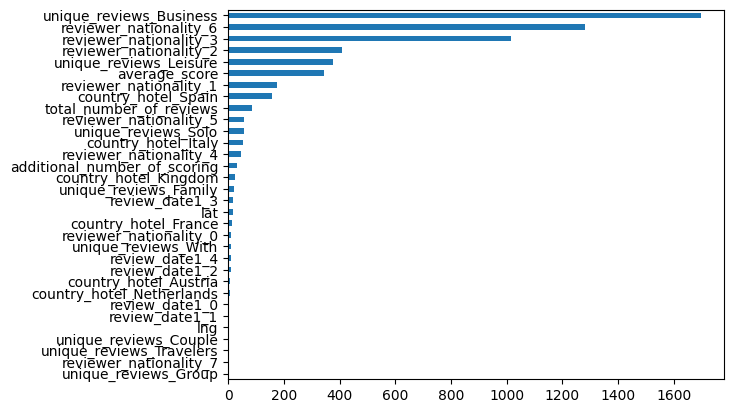

In [127]:
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

In [135]:
# удалим последних три признака
hotels_drop=hotels.drop(['reviewer_nationality_7', 'unique_reviews_Group', 'unique_reviews_Travelers', 'lng'], axis = 1)


<AxesSubplot: >

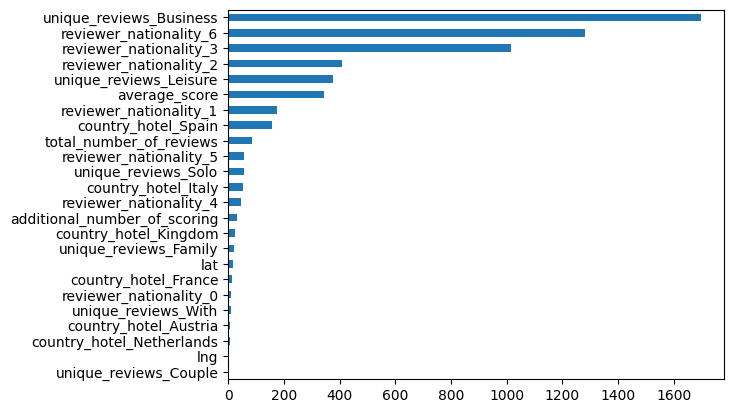

In [66]:
cat_cols = ['additional_number_of_scoring', 'average_score', 'total_number_of_reviews', 'lat', 'lng', 'unique_reviews_Leisure', 'unique_reviews_Business', 
            'unique_reviews_Family', 'unique_reviews_Solo', 'unique_reviews_Couple', 'unique_reviews_With',
            'country_hotel_Kingdom', 'country_hotel_France', 'country_hotel_Netherlands', 'country_hotel_Italy', 'country_hotel_Austria', 
            'country_hotel_Spain', 'reviewer_nationality_0', 'reviewer_nationality_1', 'reviewer_nationality_2', 'reviewer_nationality_3', 
            'reviewer_nationality_4', 'reviewer_nationality_5', 'reviewer_nationality_6']
y=y.astype('int')

...
from sklearn.feature_selection import chi2 # хи-квадрат

imp_cat = pd.Series(chi2(X[cat_cols], y)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

<AxesSubplot: >

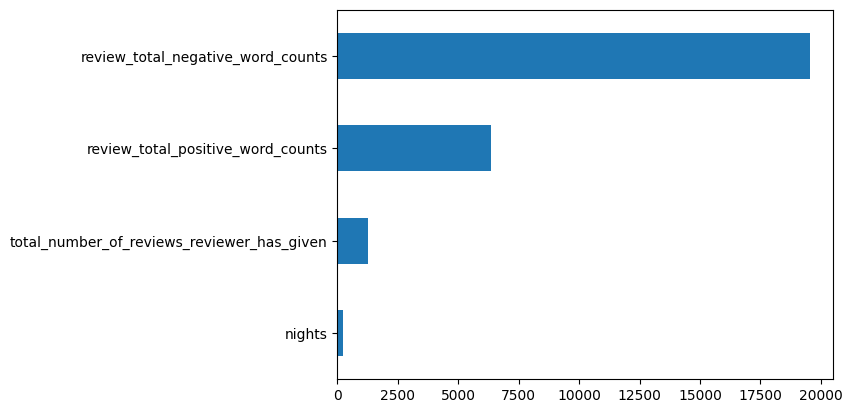

In [128]:
from sklearn.feature_selection import f_classif # anova

imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

# 5. Тестирование модели

In [136]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_drop.drop(['reviewer_score'], axis = 1)  
y = hotels_drop['reviewer_score'] 

In [137]:
# Загружаем специальный инструмент для разбивки:  
from sklearn.model_selection import train_test_split  

In [138]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [139]:
# Импортируем необходимые библиотеки:  
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели  
from sklearn import metrics # инструменты для оценки точности модели  
  
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)  


In [140]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 10639264941070.418


MAPE: 0.13744640775741515
MAPE: 10521696961127.371
MAPE: 10539858800527.465